In [1]:
import numpy as np
from keras.models import save_model, load_model, Model
from keras.layers import Input, Dropout, BatchNormalization, LeakyReLU, concatenate
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv2DTranspose
import h5py 
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import keras
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Add
from keras.applications import VGG16
from keras import layers, models

2025-05-31 21:32:44.295355: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-31 21:32:44.310561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-31 21:32:44.329054: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-31 21:32:44.334529: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-31 21:32:44.349139: I tensorflow/core/platform/cpu_feature_guar

In [2]:
fh5 = h5py.File(r'../data/imgandmasks_Highlights_processing_percentile=99.5.h5','r')
img_png_x = fh5['img']
img_png_x = np.array(img_png_x)
mask_x = fh5['masks']
mask_x = np.array(mask_x)

In [3]:
mask_x  = mask_x .reshape(len(mask_x), 288, 384, 1)
# mask_x = mask_x/255
mask_x .shape

(2987, 288, 384, 1)

In [4]:
img_png_x.max()

1.0

In [5]:
mask_x.max()

1.0

(-0.5, 383.5, 287.5, -0.5)

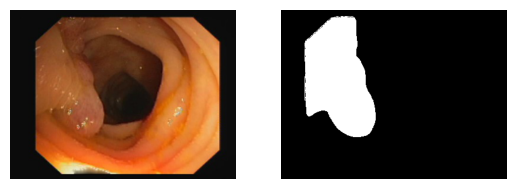

In [6]:
# 查看验证集
a = 10
plt.figure()
plt.subplot(121),plt.imshow(img_png_x[a])
plt.axis('off')
plt.subplot(122),plt.imshow(mask_x[a],'gray')
plt.axis('off')

In [7]:
# -----------------------------------------------------------------
# 从txt文件读取并恢复为NumPy数组
# -----------------------------------------------------------------
# 读取训练集
# Train = np.loadtxt('E:\wujieyu\img train PolypGen+CVC\Train.txt', dtype=int)
Train = np.loadtxt('../Train.txt', dtype=int)
# 读取验证集
# Val = np.loadtxt('E:\wujieyu\img train PolypGen+CVC\Val.txt', dtype=int)
Val = np.loadtxt('../Val.txt', dtype=int)

In [8]:
# -----------------------------------------------------------------
# 按索引划分图像数据
# -----------------------------------------------------------------
# 划分训练集（T_img_png_x）和验证集（V_img）
T_img = img_png_x[Train]
V_img = img_png_x[Val]
T_mask = mask_x[Train]
V_mask = mask_x[Val]

In [9]:
print(  T_img.shape,
        V_img.shape,
        T_mask.shape,
        V_mask.shape)

(2390, 288, 384, 3) (597, 288, 384, 3) (2390, 288, 384, 1) (597, 288, 384, 1)


(-0.5, 383.5, 287.5, -0.5)

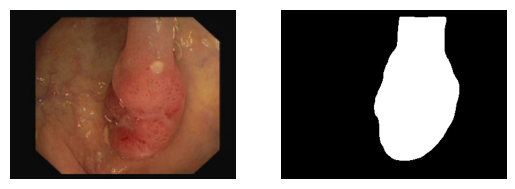

In [10]:
# 查看训练集集
a = 10
plt.figure()
plt.subplot(121),plt.imshow(T_img[a])
plt.axis('off')
plt.subplot(122),plt.imshow(T_mask[a],'gray')
plt.axis('off')

(-0.5, 383.5, 287.5, -0.5)

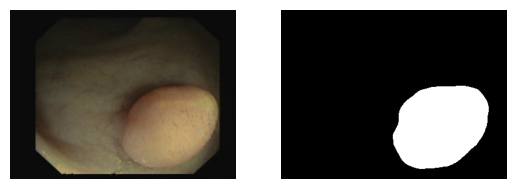

In [11]:
# 查看验证集
a = 10
plt.figure()
plt.subplot(121),plt.imshow(V_img[a])
plt.axis('off')
plt.subplot(122),plt.imshow(V_mask[a],'gray')
plt.axis('off')

In [2]:
def VggSegNet(input_shape, num_classes=1):  # 默认输出单通道（黑白掩膜）
    inputs = layers.Input(shape=input_shape)
    
    # ---------------------------- 编码器部分 ----------------------------
    # Block 1 (2卷积层)
    conv_1 = layers.Conv2D(64, (3,3), padding='same')(inputs)
    conv_1 = layers.BatchNormalization()(conv_1)
    conv_1 = layers.Activation('relu')(conv_1)
    conv_2 = layers.Conv2D(64, (3,3), padding='same')(conv_1)
    conv_2 = layers.BatchNormalization()(conv_2)
    conv_2 = layers.Activation('relu')(conv_2)
    pool_1 = layers.MaxPooling2D((2,2))(conv_2)  # 144x192

    # Block 2 (2卷积层)
    conv_3 = layers.Conv2D(128, (3,3), padding='same')(pool_1)
    conv_3 = layers.BatchNormalization()(conv_3)
    conv_3 = layers.Activation('relu')(conv_3)
    conv_4 = layers.Conv2D(128, (3,3), padding='same')(conv_3)
    conv_4 = layers.BatchNormalization()(conv_4)
    conv_4 = layers.Activation('relu')(conv_4)
    pool_2 = layers.MaxPooling2D((2,2))(conv_4)  # 72x96

    # Block 3 (3卷积层)
    conv_5 = layers.Conv2D(256, (3,3), padding='same')(pool_2)
    conv_5 = layers.BatchNormalization()(conv_5)
    conv_5 = layers.Activation('relu')(conv_5)
    conv_6 = layers.Conv2D(256, (3,3), padding='same')(conv_5)
    conv_6 = layers.BatchNormalization()(conv_6)
    conv_6 = layers.Activation('relu')(conv_6)
    conv_7 = layers.Conv2D(256, (3,3), padding='same')(conv_6)
    conv_7 = layers.BatchNormalization()(conv_7)
    conv_7 = layers.Activation('relu')(conv_7)
    pool_3 = layers.MaxPooling2D((2,2))(conv_7)  # 36x48

    # Block 4 (3卷积层)
    conv_8 = layers.Conv2D(512, (3,3), padding='same')(pool_3)
    conv_8 = layers.BatchNormalization()(conv_8)
    conv_8 = layers.Activation('relu')(conv_8)
    conv_9 = layers.Conv2D(512, (3,3), padding='same')(conv_8)
    conv_9 = layers.BatchNormalization()(conv_9)
    conv_9 = layers.Activation('relu')(conv_9)
    conv_10 = layers.Conv2D(512, (3,3), padding='same')(conv_9)
    conv_10 = layers.BatchNormalization()(conv_10)
    conv_10 = layers.Activation('relu')(conv_10)
    pool_4 = layers.MaxPooling2D((2,2))(conv_10)  # 18x24

    # Block 5 (3卷积层)
    conv_11 = layers.Conv2D(512, (3,3), padding='same')(pool_4)
    conv_11 = layers.BatchNormalization()(conv_11)
    conv_11 = layers.Activation('relu')(conv_11)
    conv_12 = layers.Conv2D(512, (3,3), padding='same')(conv_11)
    conv_12 = layers.BatchNormalization()(conv_12)
    conv_12 = layers.Activation('relu')(conv_12)
    conv_13 = layers.Conv2D(512, (3,3), padding='same')(conv_12)
    conv_13 = layers.BatchNormalization()(conv_13)
    conv_13 = layers.Activation('relu')(conv_13)
    pool_5 = layers.MaxPooling2D((2,2))(conv_13)  # 9x12

    # ---------------------------- 解码器部分 ----------------------------
    # Block 1解码 (3卷积层，对应Block5编码)
    unpool_1 = layers.UpSampling2D((2,2))(pool_5)  # 18x24
    conv_14 = layers.Conv2D(512, (3,3), padding='same')(unpool_1)
    conv_14 = layers.BatchNormalization()(conv_14)
    conv_14 = layers.Activation('relu')(conv_14)
    conv_15 = layers.Conv2D(512, (3,3), padding='same')(conv_14)
    conv_15 = layers.BatchNormalization()(conv_15)
    conv_15 = layers.Activation('relu')(conv_15)
    conv_16 = layers.Conv2D(512, (3,3), padding='same')(conv_15)
    conv_16 = layers.BatchNormalization()(conv_16)
    conv_16 = layers.Activation('relu')(conv_16)

    # Block 2解码 (3卷积层，对应Block4编码)
    unpool_2 = layers.UpSampling2D((2,2))(conv_16)  # 36x48
    conv_17 = layers.Conv2D(512, (3,3), padding='same')(unpool_2)
    conv_17 = layers.BatchNormalization()(conv_17)
    conv_17 = layers.Activation('relu')(conv_17)
    conv_18 = layers.Conv2D(512, (3,3), padding='same')(conv_17)
    conv_18 = layers.BatchNormalization()(conv_18)
    conv_18 = layers.Activation('relu')(conv_18)
    conv_19 = layers.Conv2D(256, (3,3), padding='same')(conv_18)
    conv_19 = layers.BatchNormalization()(conv_19)
    conv_19 = layers.Activation('relu')(conv_19)

    # Block 3解码 (3卷积层，对应Block3编码)
    unpool_3 = layers.UpSampling2D((2,2))(conv_19)  # 72x96
    conv_20 = layers.Conv2D(256, (3,3), padding='same')(unpool_3)
    conv_20 = layers.BatchNormalization()(conv_20)
    conv_20 = layers.Activation('relu')(conv_20)
    conv_21 = layers.Conv2D(256, (3,3), padding='same')(conv_20)
    conv_21 = layers.BatchNormalization()(conv_21)
    conv_21 = layers.Activation('relu')(conv_21)
    conv_22 = layers.Conv2D(128, (3,3), padding='same')(conv_21)
    conv_22 = layers.BatchNormalization()(conv_22)
    conv_22 = layers.Activation('relu')(conv_22)

    # Block 4解码 (2卷积层，对应Block2编码)
    unpool_4 = layers.UpSampling2D((2,2))(conv_22)  # 144x192
    conv_23 = layers.Conv2D(128, (3,3), padding='same')(unpool_4)
    conv_23 = layers.BatchNormalization()(conv_23)
    conv_23 = layers.Activation('relu')(conv_23)
    conv_24 = layers.Conv2D(64, (3,3), padding='same')(conv_23)
    conv_24 = layers.BatchNormalization()(conv_24)
    conv_24 = layers.Activation('relu')(conv_24)

    # Block 5解码 (2卷积层，对应Block1编码)
    unpool_5 = layers.UpSampling2D((2,2))(conv_24)  # 288x384
    conv_25 = layers.Conv2D(64, (3,3), padding='same')(unpool_5)
    conv_25 = layers.BatchNormalization()(conv_25)
    conv_25 = layers.Activation('relu')(conv_25)
    conv_26 = layers.Conv2D(64, (3,3), padding='same')(conv_25)  # 新增对称卷积层
    conv_26 = layers.BatchNormalization()(conv_26)
    conv_26 = layers.Activation('relu')(conv_26)

    # 输出层（移除BN，直接Sigmoid）
    outputs = layers.Conv2D(num_classes, (1,1), padding='valid', activation='sigmoid')(conv_26)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [3]:
model = VggSegNet(input_shape=(288, 384, 3), num_classes=1)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2025-05-31 21:32:49.076143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79181 MB memory:  -> device: 0, name: NVIDIA A800 80GB PCIe, pci bus id: 0000:98:00.0, compute capability: 8.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 288, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 288, 384, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 288, 384, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 288, 384, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 288, 384, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 288, 384, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 288, 384, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 144, 192, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 144, 192, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 144, 192, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 144, 192, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 144, 192, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 144, 192, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 144, 192, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 72, 96, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 96, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 72, 96, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 72, 96, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 96, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 72, 96, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 72, 96, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 72, 96, 256)    │       590,08

 Total params: 29,496,129 (112.52 MB)

 Trainable params: 29,480,129 (112.46 MB)

 Non-trainable params: 16,000 (62.50 KB)

In [4]:
import tensorflow as tf

def bce_jaccard_loss(y_true, y_pred, smooth=1e-7, alpha=0.5):
    """
    参数说明：
    - y_true: 真实标签 (shape=[batch, H, W, 1])
    - y_pred: 模型预测值 (shape=[batch, H, W, 1])
    - smooth: 防止除零的小常数
    - alpha: 平衡 BCE 和 Jaccard 的权重（默认 0.5）
    """
    # 计算二元交叉熵
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # 计算 Jaccard Loss (IoU Loss)  
    y_true_f = tf.keras.backend.flatten(y_true)   # 展平为向量 [batch*H*W]
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    jaccard_loss = 1 - jaccard  # 将 IoU 转换为 Loss
    
    # 加权组合
    return alpha * bce + (1 - alpha) * jaccard_loss

In [5]:
def dice_score(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    return (2.0 * intersection + smooth) / (denominator + smooth)

In [6]:
def iou_score(y_true, y_pred, smooth=1e-7):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [7]:
model.compile(
    optimizer='Adam',
    loss=bce_jaccard_loss,  # 可替换为 iou_loss 或 bce_jaccard_loss
    metrics=[
        dice_score, 
        iou_score
        # tf.keras.metrics.BinaryAccuracy()  # 可选：添加准确率指标
    ]
)

In [18]:
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(  monitor='val_iou_score',  # 监控指标（默认：val_loss）
                                        factor=0.5,               # 学习率衰减系数（新学习率 = 旧学习率 * factor）
                                        patience=20,              # 等待 epoch 数无改善后触发
                                        mode='max'              # 监控指标方向：'auto'/'min'/'max'（自动检测最大/最小化）
                                        # min_delta=0.0001,         # 视为“改善”的最小变化阈值
                                        # cooldown=0,               # 触发后暂停监控的 epoch 数（防止频繁调整）
                                        # min_lr=0                  # 学习率下限（避免过小导致训练停滞）
                                     ),

    
    keras.callbacks.ModelCheckpoint(filepath=r'../best weight/SegNet-VGG/FMM+percentile=99.5(1)/img_best_epoch_{epoch:03d}_val_iou_{val_iou_score:.4f}.weights.h5', 
                                    # 保存路径（支持 epoch 变量，如 model_{epoch:02d}.h5）
                                    monitor='val_iou_score',
                                    save_best_only=True,           # 只保留最优模型
                                    save_weights_only=True,       # 若为 True 只保存权重，否则保存完整模型
                                    mode='max'                   # 监控指标方向（与 ReduceLROnPlateau 相同）
                                   )   ##保存最佳模型
                                      
    #keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', 
                                  #baseline=None, restore_best_weights=False)
    ]

In [19]:

# 模型训练
model.fit(
       x=T_img,
       y=T_mask,
       # validation_split=0.2,  # 验证集
       batch_size=64,
       epochs=300,
       validation_data=(V_img, V_mask),
       callbacks = callbacks_list
)

Epoch 1/300


I0000 00:00:1747110781.413732  762161 service.cc:146] XLA service 0x7fd474001b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747110781.413826  762161 service.cc:154]   StreamExecutor device (0): NVIDIA A800 80GB PCIe, Compute Capability 8.0
2025-05-13 12:33:01.873119: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-13 12:33:03.375861: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-05-13 12:33:17.863725: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,288,384]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,288,384]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_que

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_score: 0.2061 - iou_score: 0.1160 - loss: 0.6574   

2025-05-13 12:35:24.422628: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_10', 20 bytes spill stores, 28 bytes spill loads

2025-05-13 12:35:30.500515: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 4 bytes spill stores, 4 bytes spill loads



38/38 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - dice_score: 0.2071 - iou_score: 0.1167 - loss: 0.6559 - val_dice_score: 0.1948 - val_iou_score: 0.1090 - val_loss: 116.2291 - learning_rate: 0.0010
Epoch 2/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 534ms/step - dice_score: 0.3128 - iou_score: 0.1857 - loss: 0.5536 - val_dice_score: 2.2892e-11 - val_iou_score: 1.1537e-11 - val_loss: 15.3702 - learning_rate: 0.0010
Epoch 3/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 554ms/step - dice_score: 0.3983 - iou_score: 0.2491 - loss: 0.5092 - val_dice_score: 0.1967 - val_iou_score: 0.1102 - val_loss: 10.5836 - learning_rate: 0.0010
Epoch 4/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 546ms/step - dice_score: 0.4554 - iou_score: 0.2953 - loss: 0.4818 - val_dice_score: 0.2059 - val_iou_score: 0.1161 - val_loss: 2.5040 - learning_rate: 0.0010
Epoch 5/300
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 527ms/step - dice_score: 0.4606 - iou_score: 0.3005 - loss: 0.4775 - val_dice_score: 0.0905 - val_iou_score: 0.0479 - val_loss: 0.8204 - learning_rate:

In [4]:
# 读取测试集
fh5 = h5py.File(r'../data//test/TestDataset/CVC-ColonDB/images/test_CVC-ColonDB_imgandmasks.h5','r')
img_png_c = fh5['img']
img_png_c = np.array(img_png_c)
mask_c = fh5['masks']
mask_c = np.array(mask_c)

In [5]:
img_png_c.max()

1.0

In [6]:
mask_c[1].max()

255.0

In [7]:
mask_c = mask_c/255
mask_c[1].max()

1.0

In [8]:
# 读取测试集
fh5 = h5py.File(r'../data//test/TestDataset/CVC-ColonDB/img Highlights processing FMM/test_CVC-ColonDB_imgandmasks_Highlights_percentile=99.5.h5','r')
img_png_c1 = fh5['img']
img_png_c1 = np.array(img_png_c1)
mask_c1 = fh5['masks']
mask_c1 = np.array(mask_c1)

In [9]:
img_png_c1.max()

1.0

In [10]:
mask_c1.max()

1.0

(-0.5, 383.5, 287.5, -0.5)

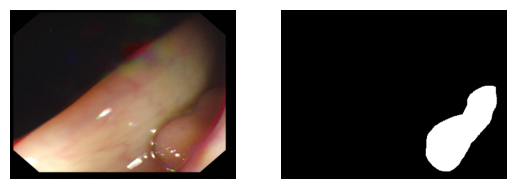

In [11]:
a = 10
plt.figure()
plt.subplot(121),plt.imshow(img_png_c[a])
plt.axis('off')
plt.subplot(122),plt.imshow(mask_c[a],'gray')
plt.axis('off')

(-0.5, 383.5, 287.5, -0.5)

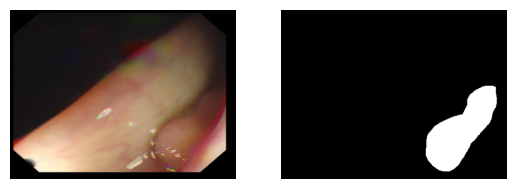

In [12]:
a = 10
plt.figure()
plt.subplot(121),plt.imshow(img_png_c1[a])
plt.axis('off')
plt.subplot(122),plt.imshow(mask_c1[a],'gray')
plt.axis('off')

In [16]:
model.compile(
    optimizer='adam',
    loss=bce_jaccard_loss,
    metrics=[dice_score, iou_score]
)

In [17]:
# # 加载模型
model.load_weights(r'../best weight/SegNet-VGG/img/img_best_epoch_173_val_iou_0.7194.weights.h5')

/data/wujieyu/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 214 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [18]:
# 原图评估模型（返回 loss + metrics）
results = model.evaluate(img_png_c, mask_c, verbose=0)

I0000 00:00:1748075114.751668 2504090 service.cc:146] XLA service 0x7fd644026bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748075114.751736 2504090 service.cc:154]   StreamExecutor device (0): NVIDIA A800 80GB PCIe, Compute Capability 8.0
2025-05-24 16:25:14.830724: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-24 16:25:15.092850: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
2025-05-24 16:25:21.951375: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1748075121.974275 2504090 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-05-2

In [19]:
# 打印所有指标名称和值
print("\n=== 测试结果 ===")
print(f"Loss: {results[0]:.4f}")
print(f"dice_score: {results[1]:.4f}")
print(f"iou_score: {results[2]:.4f}")


=== 测试结果 ===
Loss: 0.4319
dice_score: 0.7281
iou_score: 0.6065


In [20]:
# # 加载模型
model.load_weights(r'../best weight/SegNet-VGG/FMM+percentile=99.5/img_best_epoch_143_val_iou_0.7171.weights.h5')

In [21]:
# 原图评估模型（返回 loss + metrics）
results1 = model.evaluate(img_png_c1, mask_c1, verbose=0)

In [22]:
# 打印所有指标名称和值
print("\n=== 测试结果 ===")
print(f"Loss: {results1[0]:.4f}")
print(f"dice_score: {results1[1]:.4f}")
print(f"iou_score: {results1[2]:.4f}")


=== 测试结果 ===
Loss: 0.4321
dice_score: 0.7211
iou_score: 0.5967


In [13]:
# # 加载模型
model.load_weights(r'../best weight/SegNet-VGG/img/img_best_epoch_173_val_iou_0.7194.weights.h5')

In [14]:
#测试mask
imgp = model.predict(img_png_c, verbose=1)

I0000 00:00:1748698385.902404 1556882 service.cc:146] XLA service 0x7f7b8c003390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748698385.902515 1556882 service.cc:154]   StreamExecutor device (0): NVIDIA A800 80GB PCIe, Compute Capability 8.0
2025-05-31 21:33:05.960043: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-31 21:33:06.208497: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

I0000 00:00:1748698392.193852 1556882 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 629ms/step


In [15]:
# # 加载模型
model.load_weights(r'../best weight/SegNet-VGG/FMM+percentile=99.5/img_best_epoch_143_val_iou_0.7171.weights.h5')

In [16]:
#测试mask
imgp1 = model.predict(img_png_c1, verbose=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


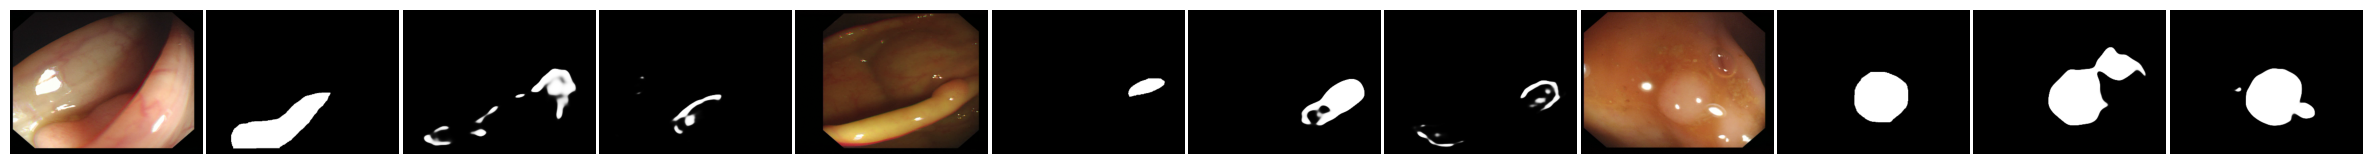

In [17]:
a, b, c = 8, 117, 311

# 设置更大的画布和紧凑布局
plt.figure(figsize=(24, 6))  # 宽度增加，高度适当调整
plt.subplots_adjust(wspace=0.02, 
                    left=0.01, 
                    right=0.99, 
                    top=0.5, 
                    bottom=0.05)  # 调整左右边距和子图间距

# 第1组子图
plt.subplot(1,12,1)
plt.imshow(img_png_c[a])
plt.axis('off')
plt.subplot(1,12,2)
plt.imshow(mask_c[a], 'gray')
plt.axis('off')
plt.subplot(1,12,3)
plt.imshow(imgp[a].reshape(288, 384), cmap='gray')
plt.axis('off')
plt.subplot(1,12,4)
plt.imshow(imgp1[a].reshape(288, 384), cmap='gray')
plt.axis('off')
# 第2组子图
plt.subplot(1,12,5)
plt.imshow(img_png_c[b])
plt.axis('off')
plt.subplot(1,12,6)
plt.imshow(mask_c[b], 'gray')
plt.axis('off')
plt.subplot(1,12,7)
plt.imshow(imgp[b].reshape(288, 384), cmap='gray')
plt.axis('off')
plt.subplot(1,12,8)
plt.imshow(imgp1[b].reshape(288, 384), cmap='gray')
plt.axis('off')
# 第3组子图
plt.subplot(1,12,9)
plt.imshow(img_png_c[c])
plt.axis('off')
plt.subplot(1,12,10)
plt.imshow(mask_c[c], 'gray')
plt.axis('off')
plt.subplot(1,12,11)
plt.imshow(imgp[c].reshape(288, 384), cmap='gray')
plt.axis('off')
plt.subplot(1,12,12)
plt.imshow(imgp1[c].reshape(288, 384), cmap='gray')
plt.axis('off')

plt.show()

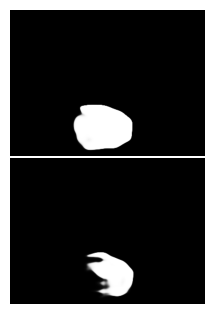

In [17]:
a = 79
# 创建紧凑画布
fig = plt.figure(figsize=(6, 3))

# 使用GridSpec控制微小边距
gs = fig.add_gridspec(2, 1, 
                     hspace=0.02,  # 行间距
                     left=0.01,    # 左边距
                     right=0.99,   # 右边距
                     top=0.99,     # 上边距
                     bottom=0.01)  # 下边距

# 添加图像子图
ax1 = fig.add_subplot(gs[0])
ax1.imshow(imgp[a].reshape(288, 384), 'gray')
ax1.axis('off')
ax1.margins(0.01)  # 图像周围微小边距

ax2 = fig.add_subplot(gs[1])
ax2.imshow(imgp1[a].reshape(288, 384), 'gray')
ax2.axis('off')
ax2.margins(0.01)  # 图像周围微小边距

# 显示紧凑布局
plt.show()